# Change-point study

[Change point analysis](http://www.variation.com/cpa/tech/changepoint.html) or [change detection](https://en.wikipedia.org/wiki/Change_detection) deals with abrupt changes in statistical properties of time series. *bayesloop* includes two types abrupt changes: an abrupt change in parameter values is modeled by the transition model `ChangepointModel`. In contrast to this change in value, the transition model itself may change at specific points in time, which we will refer to as *structural breaks*. These structural changes are implemented using the `SerialTransitionModel` class. The following two sections introduce the `ChangepointStudy` class and describe its usage to analyze both change-points and structural breaks in time series data.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt # plotting
import seaborn as sns           # nicer plots
sns.set_style('whitegrid')      # plot styling

import bayesloop as bl
import numpy as np

## Analyzing abrupt changes of parameter values

The `ChangepointStudy` class represents an extention of the `HyperStudy` introduced above and provides an easy-to-use interface to conduct change-point studies. By calling the `fit` method, this type of study first analyzes the defined transition model and detects all instances of `ChangepointModel`. Instead of directly using all combinations of predefined change-points provided by the user, it then computes a list of all valid combinations of change-point times and fits them (basically preventing the double-counting of change-point times due to reversed order). With Bayesian evidence as an objective fitness measure, this type of study can be used to answer the general question of when changes have happened. Furthermore, we may compute a distribution of change-point times to assess the (un-)certainty of these points in time.

### Analysis of a single change-point
In a first example, we assume a single change-point in our data set of coal mining disasters. Using the `ChangepointStudy`, we iterate over all possible time steps using the change-point model. After processing all time steps, the probability distribution of the change-point as well as an average model are computed. This study may also be carried out using MCMC methods, see e.g. the [PyMC tutorial](https://pymc-devs.github.io/pymc/tutorial.html) for comparison.

The change-point study is set up as shown below. Note that we supply the value `'all'` to the change-point hyper-parameter `'tChange'`, indicating that all possible time steps are considered as a change-point. One could of course also provide a list of possible candidate time steps.

In [2]:
S = bl.ChangepointStudy()

S.loadExampleData()
S.setObservationModel(bl.om.Poisson('accident rate', bl.oint(0, 6, 1000)))

T = bl.tm.ChangePoint('change point', 'all')
S.setTransitionModel(T)

S.fit()

+ Created new study.
  --> Hyper-study
  --> Change-point analysis
+ Successfully imported example data.
+ Observation model: Poisson. Parameter(s): ['accident rate']
+ Transition model: Change-point model. Hyper-Parameter(s): ['change point']
+ Detected 1 change-point(s) in transition model: ['change point']
+ Set hyper-prior(s): ['flat']
+ Started new fit.
    + 109 analyses to run.

    + Computed average posterior sequence
    + Log10-evidence of average model: -77.93783
    + Computed hyper-parameter distribution
    + Computed local evidence of average model
    + Computed mean parameter values.
+ Finished fit.


After all fits are completed, we can plot the change-point distribution, by using the method `getHyperParameterDistribution`. We may further access the time stamps and corresponding probability values to draw quantitative conclusions from them:

0.839092040278


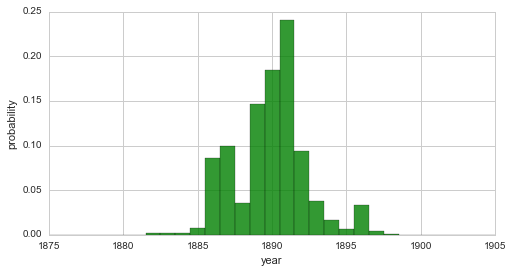

In [3]:
plt.figure(figsize=(8, 4))

t, p = S.getHyperParameterDistribution('change point', plot=True, color='g', alpha=.8)

plt.xlim([1875, 1905])
plt.xlabel('year')

# compute probability of change-point between 1887 and 1893
mask = (t >= 1887)*(t <= 1893)
print np.sum(p[mask])

From this distribution, we may conclude that a change in safety conditions of coal mines in the UK happened during the seven-year interval from 1887 to 1893 with a probability of $\approx 84\%$.

*bayesloop* further weighs all fitted models by their probability from the change-point distribution and subsequently adds them up, resulting in an average model, which is stored in `S.posteriorSequence` and `S.posteriorMeanValues`. Additionally, the log-evidence of the average model is set by the weighted sum of all log-evidence values. These results can be plotted as before, using `plotParameterEvolution`:

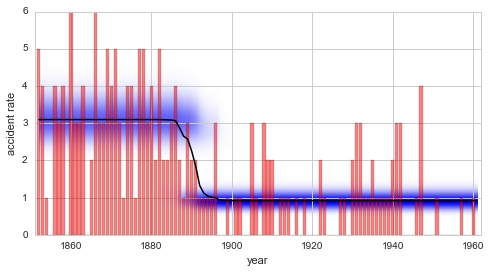

In [4]:
plt.figure(figsize=(8, 4))
plt.bar(S.rawTimestamps, S.rawData, align='center', facecolor='r', alpha=.5)
S.plotParameterEvolution('accident rate')
plt.xlim([1851, 1962])
plt.xlabel('year')

### Exploring possible change-points
The change-point study described above explicitely assumes the existence of a single change-point in the data set. Without any prior knowledge about the data, however, this assumption can rarely be made with certainty as the number of potential change-points is often unknown.

In order to *explore* possible change-points withour prior knowledge, *bayesloop* includes the transition model `RegimeSwitch`, which assigns a minimal probability (specified on a log<sub>10</sub>-scale by `log10pMin`, relative to the probability value of a flat distribution) to all parameter values on the parameter grid at every time step. This model allows for abrupt parameter changes only, and neglects gradually varying parameter dynamics. Note that no `ChangepointStudy` is needed for this kind of analysis, the *"standard"* `Study` class is sufficient.

For the coal mining example, the results from the regime-switching model with a minimal probability of $10^{-7}$ resemble the average model of the change-point study:

+ Created new study.
+ Successfully imported example data.
+ Observation model: Poisson. Parameter(s): ['accident rate']
+ Transition model: Regime-switching model. Hyper-Parameter(s): ['log10pMin']
+ Started new fit:
    + Formatted data.
    + Set prior (function): jeffreys
    + Finished forward pass.
    + Log10-evidence: -82.86009
    + Finished backward pass.
    + Computed mean parameter values.


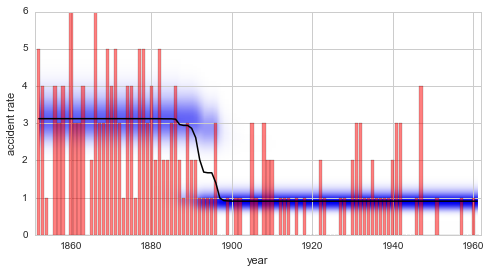

In [5]:
S = bl.Study()

S.loadExampleData()
S.setObservationModel(bl.om.Poisson('accident rate', bl.oint(0, 6, 1000)))

T = bl.tm.RegimeSwitch('log10pMin', -7)
S.setTransitionModel(T)

S.fit()

plt.figure(figsize=(8, 4))
plt.bar(S.rawTimestamps, S.rawData, align='center', facecolor='r', alpha=.5)
S.plotParameterEvolution('accident rate')
plt.xlim([1851, 1962])
plt.xlabel('year')

### Analysis of multiple change-points
Suppose the regime-switching process introduced above indicates two distinct change-points in a data set. In this case, the `ChangepointStudy` class can be used together with a `CombinedTransitionModel` to perform a comprehensive analysis assuming two change-points. The combined transition model here simply consists of two instances of the `ChangePoint` model. We use the example below to investigate possible change-points in the disaster rate after the significant decrease at the end of the 19th century, i.e. restricting the data set to the time after 1900. Note that the `ChangepointStudy` will only consider combinations of change-points that are in ascending temporal order, i.e. the second change-point must occur after the first one.

After all fits are done, the resulting joint change-point distribution can be plotted using the `getJointHyperParameterDistribution` method (similar to plotting the joint distribution of a hyper-study).

+ Created new study.
  --> Hyper-study
  --> Change-point analysis
+ Successfully imported example data.
+ Observation model: Poisson. Parameter(s): ['accident rate']
+ Transition model: Combined transition model. Hyper-Parameter(s): ['t_1', 't_2']
+ Detected 2 change-point(s) in transition model: ['t_1', 't_2']
+ Set hyper-prior(s): ['flat', 'flat']
+ Started new fit.
    + 1770 analyses to run.

    + Computed average posterior sequence
    + Log10-evidence of average model: -37.08010
    + Computed hyper-parameter distribution
    + Computed local evidence of average model
    + Computed mean parameter values.
+ Finished fit.


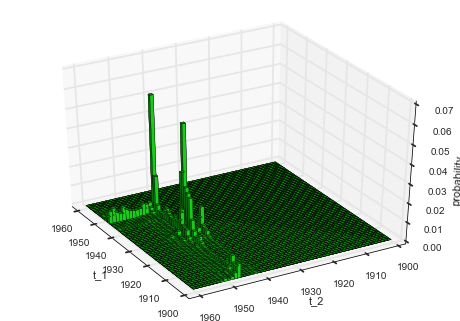

In [6]:
S = bl.ChangepointStudy()
S.loadExampleData()
S.setObservationModel(bl.om.Poisson('accident rate', bl.oint(0, 6, 1000)))

mask = S.rawTimestamps > 1900 # select timestamps greater than the year 1900
S.rawTimestamps = S.rawTimestamps[mask]
S.rawData = S.rawData[mask]

T = bl.tm.CombinedTransitionModel(bl.tm.ChangePoint('t_1', 'all'),
                                  bl.tm.ChangePoint('t_2', 'all'))

S.setTransitionModel(T)
S.fit()

S.getJointHyperParameterDistribution(['t_1', 't_2'], plot=True, color=[0.1, 0.8, 0.1])
plt.xlim([1899, 1962])
plt.ylim([1899, 1962])

# set proper view-point
ax = plt.gca()
ax.view_init(elev=35, azim=150)

Instead of focusing on the exact time steps of the change-points, some applications may call for the analysis of the time interval between two change-points. The `ChangepointStudy` class provides a method called `getDurationDistribution` which computes the probabilities of different time intervals between two change-points and optionally plots them in a bar graph. Based on the example above, the resulting *"duration distribution"* is shown below:

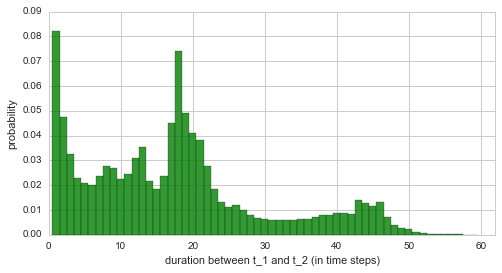

In [7]:
plt.figure(figsize=(8, 4))
S.getDurationDistribution(['t_1', 't_2'], plot=True, color='g', alpha=.8)
plt.xlim([0, 62]);

Finally, we plot the averaged parameter evolution of the two-change-point model. From the duration distribution as well as from the temporal evolution of the inferred disaster rate we may conclude that there is indeed a time period with a slightly increased disaster rate, which begins in $\approx$ 1930 and ends in $\approx$ 1945. The duration distribution underlines this finding with high probability values for durations up to 20 years.

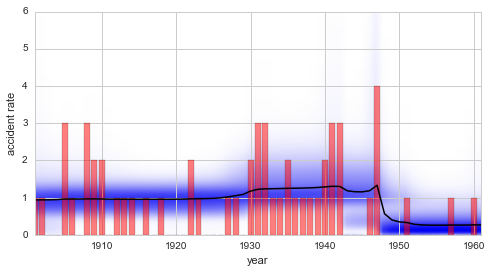

In [8]:
plt.figure(figsize=(8, 4))
plt.bar(S.rawTimestamps, S.rawData, align='center', facecolor='r', alpha=.5)
S.plotParameterEvolution('accident rate')
plt.xlim([1901, 1961])
plt.xlabel('year')

## Analyzing structural breaks in time series models
In contrast to a pure change in parameter value, the whole type of parameter dynamics may change at a given point in time. We will use the term *structural break* to describe such events. We have already investigated so-called serial transition models that describe parameter dynamics which change from time to time. While these serial transition models are a re-occurring topic in this tutorial (see [here](modelselection.html#Serial-transition-model), [here](hyperparameteroptimization.html) and [here](hyperstudy.html)), the times at which the structural breaks happen have - up to this point - always been user-defined and fixed. This restriction can be lifted by the `ChangepointStudy` class. If a `SerialTransitionModel` is defined within the change-point study, all structural breaks will be treated as variables and the `fit` method will interate over all possible combinations, just as with *"normal"* change-points.

In this section, our goal is to build a model to determine how long it took for the disaster rate to decrease from $\approx$ 3 disasters per year to only $\approx$ 1 per year. This kind of study may generally be applied to assess the effectivity of policies like safety regulations. Here, we devise a simple serial transition model that consists of three phases to describe the change in the annual number of coal mining disasters: in the first and the last phase, we assume a constant disaster rate, while the intermediate phase is modelled by a linear decrease of the disaster rate. By providing multiple values for the slope of the intermediate phase, we can combine the advantages of both hyper- and change-point study in order to consider the uncertainty of the change-points *and* the uncertainty of the slope of the intermediate phase. We restrict the data set to the years from 1870 to 1910, and assume an improvement of the disaster rate by 0 to 2.0 disasters per year.

_**Note:** The following analysis consists of ~25000 individual model fits. It may take several minutes to complete._

+ Successfully imported example data.
['all', 'all']
+ Transition model: Serial transition model. Hyper-Parameter(s): ['slope', 't_1', 't_2']
+ Detected 2 break-point(s) in transition model: ['t_1', 't_2']
+ Set hyper-prior(s): ['flat', 'flat', 'flat']
+ Started new fit.
    + 23400 analyses to run.
    ! WARNING: Posterior distribution contains only zeros, check parameter boundaries!
      Stopping inference process. Setting model evidence to zero.

    + Computed average posterior sequence
    + Log10-evidence of average model: -32.86176
    + Computed hyper-parameter distribution
    + Computed local evidence of average model
    + Computed mean parameter values.
+ Finished fit.


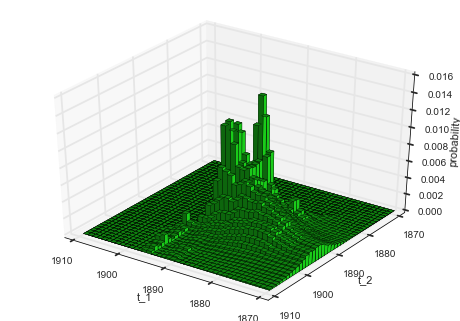

In [9]:
S.loadExampleData()

mask = (S.rawTimestamps >= 1870)*(S.rawTimestamps <= 1910) # restrict analysis to 1870-1910
S.rawTimestamps = S.rawTimestamps[mask]
S.rawData = S.rawData[mask]

T = bl.tm.SerialTransitionModel(bl.tm.Static(),
                                bl.tm.BreakPoint('t_1', 'all'),
                                bl.tm.Deterministic(lambda t, slope=np.linspace(-2.0, 0.0, 30): t*slope, 
                                                    target='accident rate'),
                                bl.tm.BreakPoint('t_2', 'all'),
                                bl.tm.Static()
                                )

S.setTransitionModel(T)
S.fit()

S.getJointHyperParameterDistribution(['t_1', 't_2'], plot=True, color=[0.1, 0.8, 0.1])
plt.xlim([1869, 1911])
plt.ylim([1869, 1911])

# set proper view-point
ax = plt.gca()
ax.view_init(elev=35, azim=125)

Apart from this rather non-intuitive joint distribution of the two structural break times, we can also plot the marginal distribution of the inferred slope of the intermediate phase. This is done by calling the `getHyperParameterDistribution` method, which the `ChangepointStudy` class inherits from the `HyperStudy` class. Note that all plot-functions for hyper-parameters by default return the values and corresponding probability (density) values for further analyses:

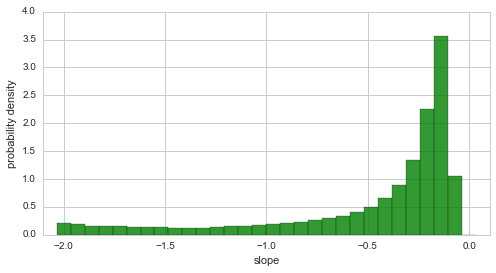

In [10]:
plt.figure(figsize=(8,4))
s, p = S.getHyperParameterDistribution('slope', plot=True, color='g', alpha=.8)
plt.xlim([-2.1, 0.1]);

The plot above indicates that the decrease of the disaster rate is indeed a gradual process, as high probabilities are assigned to rather small slopes with an absolute value $<$0.5. However, there is still a significant probability of slopes with an absolute value that is larger than 0.5. We may determine this value by integrating over the distribution:

In [11]:
ds = s[1] - s[0] # differential for integration
np.sum(p[np.abs(s) > 0.5])*ds # integration = sum * differential

0.29265010300960131

More intuitive than the slope is the duration between the two structural breaks. This period of time directly measures the time it takes for the disaster rate to decrease from three to one disaster per year. The plot below shows the distribution for this period of time:

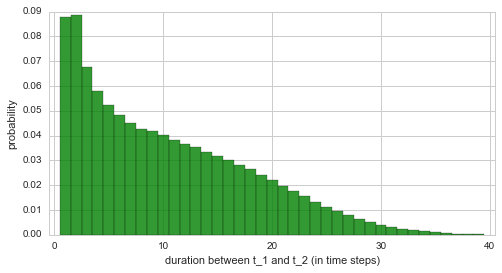

In [12]:
plt.figure(figsize=(8,4))
d, p = S.getDurationDistribution(['t_1', 't_2'], plot=True, color='g', alpha=.8)
plt.xlim([-0.5, 40.5]);

From this plot, we see that the period between the two structural breaks cannot be inferred with great accuracy. The accuracy may be improved by extending the simple serial model used in this example or by incorporating more data points (only 40 data points have been used here). We may still conclude that this analysis indicates an intermediate phase of improvement that is shorter than 15 years, with a probability of $\approx 70\%$:

In [13]:
np.sum(p[np.abs(d) < 15])

0.71545710930129347

The results from the break-point analysis are further illustrated by the temproal evolution of the inferred disaster rate. Below, the average model of the complete analysis is used to display the inferred changes in the disaster rate:

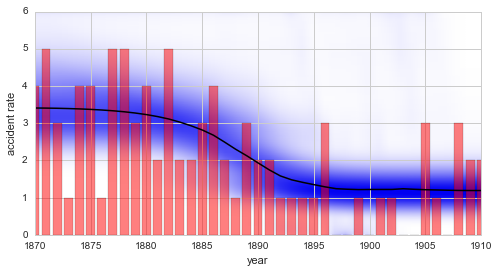

In [14]:
plt.figure(figsize=(8, 4))
plt.bar(S.rawTimestamps, S.rawData, align='center', facecolor='r', alpha=.5)
S.plotParameterEvolution('accident rate')
plt.xlim([1870, 1910])
plt.xlabel('year')